# 2A.ML101.3: Supervised Learning: Classification of Handwritten Digits

In this section we'll apply scikit-learn to the classification of handwritten
digits.  This will go a bit beyond the iris classification we saw before: we'll
discuss some of the metrics which can be used in evaluating the effectiveness
of a classification model.

*Source:* [Course on machine learning with scikit-learn](https://github.com/GaelVaroquaux/sklearn_ensae_course) by Gaël Varoquaux

In [1]:
from sklearn.datasets import load_digits
digits = load_digits()

We'll re-use some of our code from before to visualize the data and remind us what
we're looking at:

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

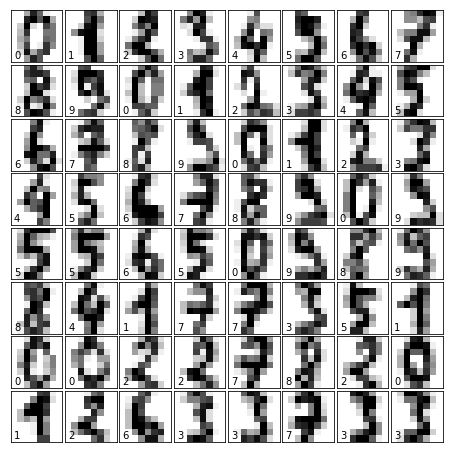

In [3]:
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

## Visualizing the Data

A good first-step for many problems is to visualize the data using a
*Dimensionality Reduction* technique.  We'll start with the
most straightforward one, Principal Component Analysis (PCA).

PCA seeks orthogonal linear combinations of the features which show the greatest
variance, and as such, can help give you a good idea of the structure of the
data set.  Here we'll use `RandomizedPCA`, because it's faster for large `N`.

In [4]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, svd_solver="randomized")
proj = pca.fit_transform(digits.data)

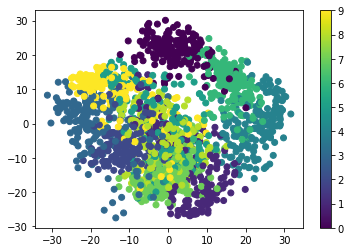

In [5]:
plt.scatter(proj[:, 0], proj[:, 1], c=digits.target)
plt.colorbar();

**Question: Given these projections of the data, which numbers do you think
a classifier might have trouble distinguishing?**

## Gaussian Naive Bayes Classification

For most classification problems, it's nice to have a simple, fast, go-to
method to provide a quick baseline classification.  If the simple and fast
method is sufficient, then we don't have to waste CPU cycles on more complex
models.  If not, we can use the results of the simple method to give us
clues about our data.

One good method to keep in mind is Gaussian Naive Bayes.  It fits a Gaussian distribution to each training label independantly on each feature, and uses this to quickly give a rough classification.  It is generally not sufficiently accurate for real-world data, but can perform surprisingly well, for instance on text data.

In [6]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

In [7]:
# split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target)

# train the model
clf = GaussianNB()
clf.fit(X_train, y_train)

# use the model to predict the labels of the test data
predicted = clf.predict(X_test)
expected = y_test

**Question**: why did we split the data into training and validation sets?

Let's plot the digits again with the predicted labels to get an idea of
how well the classification is working:

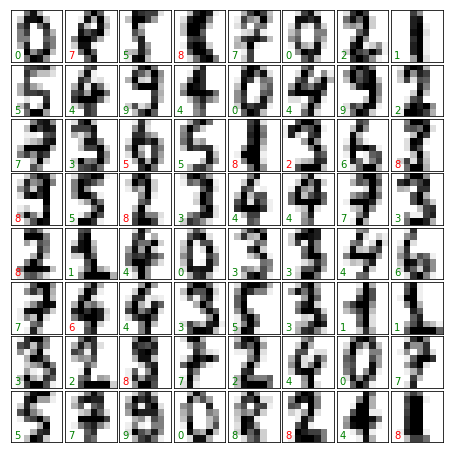

In [8]:
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(X_test.reshape(-1, 8, 8)[i], cmap=plt.cm.binary,
              interpolation='nearest')
    
    # label the image with the target value
    if predicted[i] == expected[i]:
        ax.text(0, 7, str(predicted[i]), color='green')
    else:
        ax.text(0, 7, str(predicted[i]), color='red')

## Quantitative Measurement of Performance

We'd like to measure the performance of our estimator without having to resort
to plotting examples.  A simple method might be to simply compare the number of
matches:

In [9]:
matches = (predicted == expected)
print(matches.sum())
print(len(matches))

364
450


In [10]:
matches.sum() / float(len(matches))

0.8088888888888889

We see that nearly 1500 of the 1800 predictions match the input.  But there are other
more sophisticated metrics that can be used to judge the performance of a classifier:
several are available in the ``sklearn.metrics`` submodule.

One of the most useful metrics is the ``classification_report``, which combines several
measures and prints a table with the results:

In [11]:
from sklearn import metrics
from pandas import DataFrame
DataFrame(metrics.classification_report(expected, predicted, output_dict=True)).T

,f1-score,precision,recall,support
0,0.987013,0.974359,1.000000,38.0
1,0.584615,0.826087,0.452381,42.0
2,0.734177,0.906250,0.617021,47.0
3,0.851852,0.920000,0.793103,58.0
4,0.880952,0.925000,0.840909,44.0
5,0.949495,0.940000,0.959184,49.0
6,0.952381,0.961538,0.943396,53.0
7,0.894118,0.863636,0.926829,41.0
8,0.549296,0.393939,0.906977,43.0
9,0.750000,1.000000,0.600000,35.0


Another enlightening metric for this sort of multi-label classification
is a *confusion matrix*: it helps us visualize which labels are
being interchanged in the classification errors:

In [12]:
DataFrame(metrics.confusion_matrix(expected, predicted))

,0,1,2,3,4,5,6,7,8,9
0,38,0,0,0,0,0,0,0,0,0
1,0,19,0,0,0,0,0,0,23,0
2,0,2,29,0,0,0,0,0,16,0
3,0,0,2,46,0,1,0,1,8,0
4,1,0,0,0,37,0,1,1,4,0
5,0,0,0,1,0,47,1,0,0,0
6,0,0,0,0,1,1,50,0,1,0
7,0,0,0,0,1,1,0,38,1,0
8,0,2,1,0,0,0,0,1,39,0
9,0,0,0,3,1,0,0,3,7,21


We see here that in particular, the numbers 1, 2, 3, and 9 are often being labeled 8.